In [1]:
import sys, os

os.chdir("../../")
sys.path.append("./src/data")
sys.path.append("./src/events")
sys.path.append("./src/probability")
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from IC.main import sim_events
from DC.event_processing import list_of_params_nsi
from functions import nufit_params_nsi, perform_chisq
from IC.event_processing import normalize_events, get_deltachi, z_bins
from scipy.stats import chi2
import pickle
from multiprocessing import Pool

plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100
matplotlib.rc("text", usetex=True)
matplotlib.rc("text.latex", preamble=r"\usepackage{amsmath}")
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

giunti_contour_cl90 = pd.read_csv(
    "../../src/data/files/giunti_cl90.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
IC_contour_cl90 = pd.read_csv(
    "../../src/data/files/ic_cl90.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
giunti_contour_cl99 = pd.read_csv(
    "../../src/data/files/giunti_cl99.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
IC_contour_cl99 = pd.read_csv(
    "../../src/data/files/ic_cl99.csv", header=None, names=["s24", "dm41"]
).sort_values("dm41")
ic_34_cl90 = pd.read_csv(
    "../../src/data/files/ic_34_cl90.csv", header=None, names=["s24", "s34"]
).sort_values("s34")
ic_34_cl99 = pd.read_csv(
    "../../src/data/files/ic_34_cl99.csv", header=None, names=["s24", "s34"]
).sort_values("s34")

C:\Users\Martin\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [2]:
ndim = 3
N = 13
alpha = 0.99
precomputed_events = True

dm31_range = np.linspace(2.489 * 1e-3, 2.543 * 1e-3, 9)
th23_range = np.linspace(48 * np.pi / 180, 50.1 * np.pi / 180, 9)
emm_range = np.linspace(0, 0, 1)
emt_range = np.linspace(-1e-2, 1e-2, 9)
nsi_params = nufit_params_nsi.copy()

# We want to marg over best-fit points too, so insert them
if nsi_params["dm_31"] not in dm31_range:
    dm31_range = np.sort(np.append(dm31_range, nsi_params["dm_31"]))
if nsi_params["theta_23"] not in th23_range:
    th23_range = np.sort(np.append(th23_range, nsi_params["theta_23"]))
if nsi_params["e_mm"] not in emm_range:
    emm_range = np.sort(np.append(emm_range, nsi_params["e_mm"]))
if nsi_params["e_mt"] not in emt_range:
    emt_range = np.sort(np.append(emt_range, nsi_params["e_mt"]))
param_list = list_of_params_nsi(
    nsi_params, dm31_range, th23_range, emm_range, emt_range
)

In [3]:
if not precomputed_events:
    print("Computing events")
    from multiprocessing import Pool

    p = Pool()
    data = [
        (alpha, N, p, False, False, [False, np.median(Ereco), gamma], True, True)
        for p in param_list
    ]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    pickle.dump(
        H1_events_list,
        open(
            f"../../pre_computed/H1_IC_N{N}_{len(dm31_range)}x{len(th23_range)}x{len(emm_range)}x{len(emt_range)}.p",
            "wb",
        ),
    )

    H0_events = sim_events(
        alpha=alpha,
        npoints=N,
        params=nsi_params,
        null=False,
        multi=False,
        spectral_shift=[False, np.median(Ereco), gamma],
        tau=True,
        nsi=False,
    )
    pickle.dump(H0_events, open(f"../../pre_computed/H0_IC_N{N}_nsi.p", "wb"))


H1_events_list = pickle.load(
    open(
        f"../../pre_computed/H1_IC_N{N}_{len(dm31_range)}x{len(th23_range)}x{len(emm_range)}x{len(emt_range)}.p",
        "rb",
    )
)
H0_events = pickle.load(open(f"../../pre_computed/H0_IC_N{N}_nsi.p", "rb"))

gamma = 0.3
# delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=ic_params, null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma],tau=True, nsi=True)) - np.sum(H0_events))/np.sum(H0_events)
delta_T = 0

H0_normalized, H1_list_normalized = normalize_events(H0_events, H1_events_list, z_bins)
H1_list_normalized = np.array(H1_list_normalized)

In [79]:
sigma_a = 0.25
sigma_b = 0.04
f = 0  # .1
chisq, best_index = get_deltachi(
    H1_list_normalized, delta_T, [sigma_a, sigma_b], f, x0=[1, 0]
)
reshaped_chisq = chisq.reshape(
    len(dm31_range), len(th23_range), len(emm_range), len(emt_range)
)
minimum_ax_2_and_3 = np.min(reshaped_chisq, axis=(2, 3)).reshape(
    len(dm31_range), len(th23_range), 1, 1
)
deltachi = reshaped_chisq - minimum_ax_2_and_3


best_dm31_index, best_th23_index, best_emm_index, best_emt_index = np.unravel_index(
    np.argmin(chisq), deltachi.shape
)
best_dm31, best_th23, best_emm, best_emt = (
    dm31_range[best_dm31_index],
    th23_range[best_th23_index],
    emm_range[best_emm_index],
    emt_range[best_emt_index],
)

marginalized_deltachi = deltachi[best_dm31_index, best_th23_index]

In [80]:
marginalized_deltachi

array([[0.00246954, 0.00012182, 0.        , 0.00018052, 0.00054275, 0.00093772, 0.0009599 , 0.00103177, 0.00154762]])

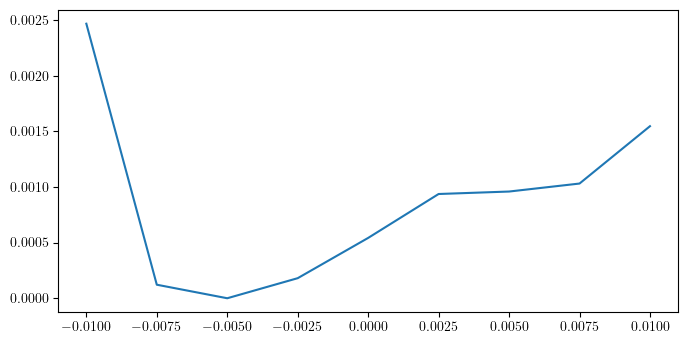

In [81]:
plt.plot(emt_range, marginalized_deltachi.reshape(-1))

In [24]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter

ic_params_nsi["dm_41"] = 0.93
plot_params = list_of_params_nsi(
    ic_params_nsi, emm_range=np.array([-0.1, 0, 0.1]), s24_range=np.array([0.1])
)
Pam = P_over_E_parameter(
    "m",
    param_dict_list=plot_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
    nsi=True,
)
Pm = P_over_E_parameter(
    "m",
    param_dict_list=plot_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
    nsi=True,
)
Pe = P_over_E_parameter(
    "e",
    param_dict_list=plot_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=False,
    nsi=True,
)
Pae = P_over_E_parameter(
    "e",
    param_dict_list=plot_params,
    E=np.logspace(3, 4, 50),
    zenith=-1,
    ndim=4,
    anti=True,
    nsi=True,
)

Pamam = Pam[:, 1]
Pamat = Pam[:, 2]
Pmm = Pm[:, 1]
Pmt = Pm[:, 2]
Pem = Pe[:, 1]
Paeam = Pae[:, 1]

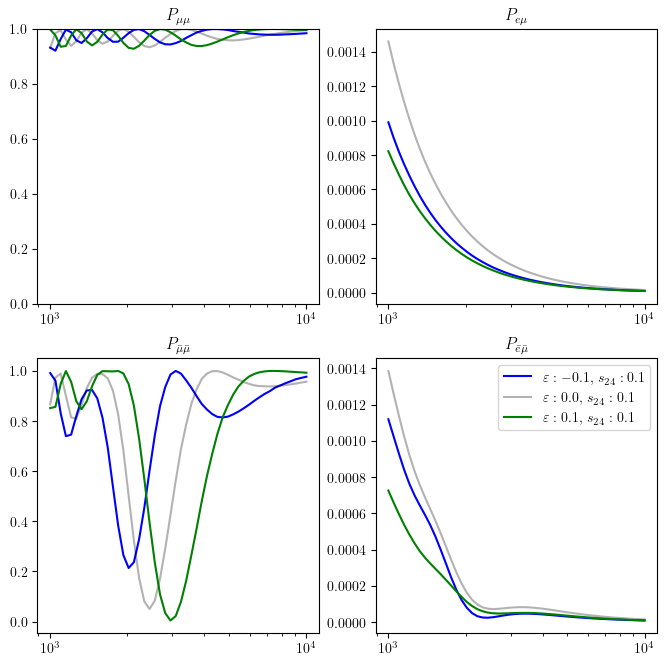

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
colors = ["blue", "black", "green"]
alpha = [1, 0.3, 1]
for i, prob in enumerate(Pmm):
    ax[0].plot(
        np.logspace(3, 4, 50),
        prob,
        c=colors[i],
        alpha=alpha[i],
        label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$',
    )

for i, prob in enumerate(Pmt):
    ax[1].plot(
        np.logspace(3, 4, 50),
        prob,
        c=colors[i],
        alpha=alpha[i],
        label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$',
    )
for i, prob in enumerate(Pamam):
    ax[2].plot(
        np.logspace(3, 4, 50),
        prob,
        c=colors[i],
        alpha=alpha[i],
        label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$',
    )
for i, prob in enumerate(Pamat):
    ax[3].plot(
        np.logspace(3, 4, 50),
        prob,
        c=colors[i],
        alpha=alpha[i],
        label=f'$\\varepsilon: {np.round(plot_params[i]["e_mm"],2)},\, s_{{24}}: {np.round(np.sin(2*plot_params[i]["theta_24"])**2,2)}$',
    )

ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[2].set_xscale("log")
ax[3].set_xscale("log")
ax[0].set_ylim((0, 1))
ax[0].set_title("$P_{\mu\mu}$")
ax[1].set_title("$P_{e\mu}$")
ax[2].set_title("$P_{\\bar{\mu}\\bar{\mu}}$")
ax[3].set_title("$P_{\\bar{e}\\bar{\mu}}$")
plt.legend()